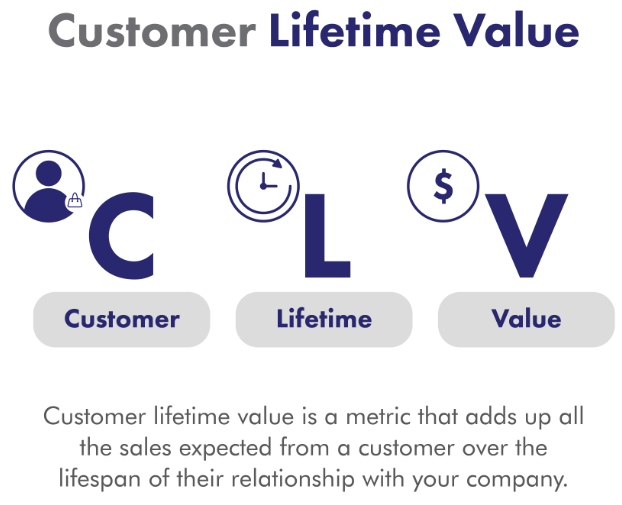

The data set named Online Retail II includes the sales of a UK-based online store between 01/12/2009 and 09/12/2011.
 
**Data set**

InvoiceNo: Invoice number. Unique number for each transaction, i.e. invoice. If it starts with C, the transaction is cancelled.

StockCode: Product code. Unique number for each product.

Description: Product name

Quantity: Number of products. It indicates how many of the products on the invoices were sold.

InvoiceDate: Invoice date and time.

UnitPrice: Product price (in Sterling)

CustomerID: Unique customer number

Country: Country name. The country where the customer lives.

In [11]:
import pandas as pd

pd.set_option('display.max_columns', 20)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.width', 1000)
df_ = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


In [12]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(90, '~'))
    print("%d rows and %d columns" % dataframe.shape)
    print(" SIZE ".center(90, '~'))
    print(dataframe.size)
    print(" TYPES ".center(90, '~'))
    print(dataframe.dtypes)
    print(" HEAD ".center(90, '~'))
    print(dataframe.head(head))
    print(" TAIL ".center(90, '~'))
    print(dataframe.tail(head))
    print(" NA ".center(90, '~'))
    print(dataframe.isna().sum())
    print(" DP ".center(90, '~'))
    print(dataframe.duplicated().sum())
    print(" CATSUM ".center(90, '~'))
    print(dataframe.describe(include="O"))
    print(" DESC ".center(90, '~'))
    quantiles = dataframe.describe([0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95,0.99]).T
    quantiles['IQR'] = quantiles['75%'] - quantiles['25%']
    print(quantiles)

check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
525461 rows and 8 columns
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SIZE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4203688
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  Invoice StockCode                          Description  Quantity         InvoiceDate   Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00 6.95000  13085.00000  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00 6.75000  1308

In [18]:
df.dropna(inplace=True)
df['Invoice'] = df['Invoice'].astype(str)
df = df[~df["Invoice"].str.contains("C", na=False)] # If it starts with C, the transaction is cancelled.
df = df[(df['Quantity'] > 0)]
df.dropna(inplace=True)
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [19]:
cltv_c = df.groupby('Customer ID').agg({'Invoice': lambda x: x.nunique(),
                                        'Quantity': lambda x: x.sum(),
                                        'TotalPrice': lambda x: x.sum()})

cltv_c.columns = ['total_transaction', 'total_unit', 'total_price']

**Average Order Value (average_order_value = total_price / total_transaction)**


In [20]:
cltv_c["average_order_value"] = cltv_c["total_price"] / cltv_c["total_transaction"]

In [21]:
cltv_c.head()

,total_transaction,total_unit,total_price,average_order_value
Customer ID,,,,
12346.00000,11,70,372.86000,33.89636
12347.00000,2,828,1323.32000,661.66000
12348.00000,1,373,222.16000,222.16000
12349.00000,3,993,2671.14000,890.38000
12351.00000,1,261,300.93000,300.93000


**Purchase Frequency (total_transaction / total_number_of_customers)**

In [22]:
cltv_c["purchase_frequency"] = cltv_c["total_transaction"] / cltv_c.shape[0]

**Repeat Rate & Churn Rate (number of customers making multiple purchases / all customers)**

In [23]:
repeat_rate = cltv_c[cltv_c["total_transaction"] > 1].shape[0] / cltv_c.shape[0]

churn_rate = 1 - repeat_rate

**Profit Margin (profit_margin =  total_price * 0.10)**

In [24]:
cltv_c['profit_margin'] = cltv_c['total_price'] * 0.10

**Customer Value (customer_value = average_order_value * purchase_frequency)**

In [25]:
cltv_c['customer_value'] = cltv_c['average_order_value'] * cltv_c["purchase_frequency"]

**Customer Lifetime Value (CLTV = (customer_value / churn_rate) x profit_margin)**

In [26]:
cltv_c["cltv"] = (cltv_c["customer_value"] / churn_rate) * cltv_c["profit_margin"]

In [27]:
cltv_c.sort_values(by="cltv", ascending=False).head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
Customer ID,,,,,,,,
18102.00000,89,124216,349164.35000,3923.19494,0.02063,34916.43500,80.93749,8579573.77276
14646.00000,78,170342,248396.50000,3184.57051,0.01808,24839.65000,57.57916,4342070.45829
14156.00000,102,108107,196566.74000,1927.12490,0.02364,19656.67400,45.56484,2719105.08615
14911.00000,205,69722,152147.57000,742.18327,0.04752,15214.75700,35.26833,1629055.80978
13694.00000,94,125893,131443.19000,1398.33181,0.02179,13144.31900,30.46898,1215855.89003


**Creating Segments**

In [28]:
cltv_c["segment"] = pd.qcut(cltv_c["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_c.groupby("segment").agg({"count", "mean", "sum"})

total_transaction              total_unit                total_price                     average_order_value  ... purchase_frequency profit_margin                    customer_value                         cltv                     
                     mean count    sum       mean count      sum        mean count           sum                mean  ...                sum          mean count          sum           mean count        sum        mean count            sum
segment                                                                                                               ...                                                                                                                     
D                 1.22892  1079   1326  109.00463  1079   117616   178.18826  1079  192265.13000           157.37300  ...            0.30737      17.81883  1079  19226.51300        0.04130  1079   44.56772     2.64071  1079     2849.32790
C                 2.00371  1078   2160  283.05659  1078   305135   475.89652  1078  513016.45300           294.45487  ...            0.50070      47.58965  1078  51301.64530        0.11031  1078  118.91897    16.86852  1078    18184.26342
B                 3.76902  1078   4063  680.15863  1078   733211  1131.35918  1078 1219605.20000           389.72832  ...            0.94182     113.13592  1078 121960.52000        0.26225  1078  282.70867    96.05739  1078   103549.86329
A                10.81186  1079  11666 4062.33735  1079  4383262  6401.40546  1079 6907116.49100           670.96592  ...            2.70422     640.14055  1079 690711.64910        1.48387  1079 1601.09330 23408.05843  1079 25257295.04118

[4 rows x 24 columns]